In [33]:
install.packages("fpp3")
install.packages("urca")

library(dplyr)
library(ggplot2)
library(fpp3)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# ARMAX, ARIMAX e SARIMAX

- Os modelos (S)AR(I)MA permitem incluir informação passada da propria série mas não permitem a inclussão de outras informações que podem também ser relevantes (incluidas como covariáveis).

- Por outro lado, os modelos de regressão permitem a inclussão de várias informações (covariáveis) mas não incorporam a dinâmica da série temporal capturadas pelos modelos da familia ARIMA.

- Aprenderemos como estender os modelos (S)AR(I)MA para permitir a que informações externas sejam incluidas no modelo.


## Motivação

Considere um ARMA(p,q) $$y_t = \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \cdots + \theta_p \epsilon_{t-p} + \epsilon_t,$$ em que $\epsilon_t \sim RB(0, \sigma_{\epsilon}^2).$



Poderiamos incluir uma (ou mais) covariáveis no lado direito da equação, da seguinte forma: $$y_t = \beta x_t + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \cdots + \theta_p \epsilon_{t-p} + \epsilon_t.$$

A desvantagem deste modelo é que $\beta$ não pode ser interpretado como usual pois a presença de valores defasados de $y$ no lado direito da equação implicam que $\beta$ só pode ser interpretado condicionalmente nos valores passados de $y$. 

Note que se utilizarmos o operador backshift, o modelo pode ser reescrito como $$\phi(B)y_t = \beta x_t + \theta(B)\epsilon_t → y_t = \dfrac{\beta}{\phi(B)}x_t + \dfrac{\theta(B)}{\phi(B)}\epsilon_t,$$ ou seja, os coeficientes do polinomio AR se misturam com a covariável e os erros.

> **Isto todo faz com que este modelo não seja utilizado, sendo preferido um modelo de regressão com erros ARMA.**


## ARMAX

Considere o seguinte modelo:

$$Y_t = \beta_0 + \beta_1 X_{t1} + \beta_2 X_{t2} + \cdots + \beta_k X_{tk} + \eta_t,$$

$$\phi(B)\eta_t = \theta(B)\epsilon_t,$$

em que $\beta_0$ é uma contante; $\beta_1, \cdots, 
\beta_k$ são os parâmetros do modelos de regressão associados às variáveis endogenas $X_1, X_2, \cdots,X_k$; $\phi(B)$ e $\theta(B)$ são os polinomios AR e MA usuais e $\epsilon_t \sim RB(0, \sigma_{\epsilon}^2).$

Se utilizarmos o operador backshift, podemos reescrever o modelo da seguinte forma: $$Y_t = \beta_0  + \displaystyle \sum_{i = 1}^k \beta_i X_{ti} + \dfrac{\theta(B)}{\phi(B)}\epsilon_t,$$ em que a interpretação dos $\beta$s permanece como usual.


> Note que as $X$s podem ser da forma $t$, $t^2$, $t^3$, ... (para capturar tendência determinística), podem ser variáveis dummy ou séries de Fourier (para capturar a sazonalidade deterministica) ou mesmo podem ser outras variáveis externas relacionadas.


**Este modelo é o que conhecemos como ARMAX ou modelos de regressão com erros ARMA ou REGARMA.**

Note que para erros ARIMA, basta substituir $\phi(B)$ por $(1-B)^d\ \phi(B)$, o que é equivalente a diferenciar $y_t$ e os $x_t$ antes de aplicar um modelo com erros ARMA.

#### Exemplo 01 (Brockwell e Davis, 2016): overshort data

_overshort_: Seja $y_t$ é a quantidade de combustível em um tanque subterrâneo de gasolina ao final do dia $t$ e seja $a_t$ a quantidade de combustível vendida durante o dia $t$, o _overshort_ no final do dia $t$ é definido como $y_t - y_{t-1} + a_t$ 


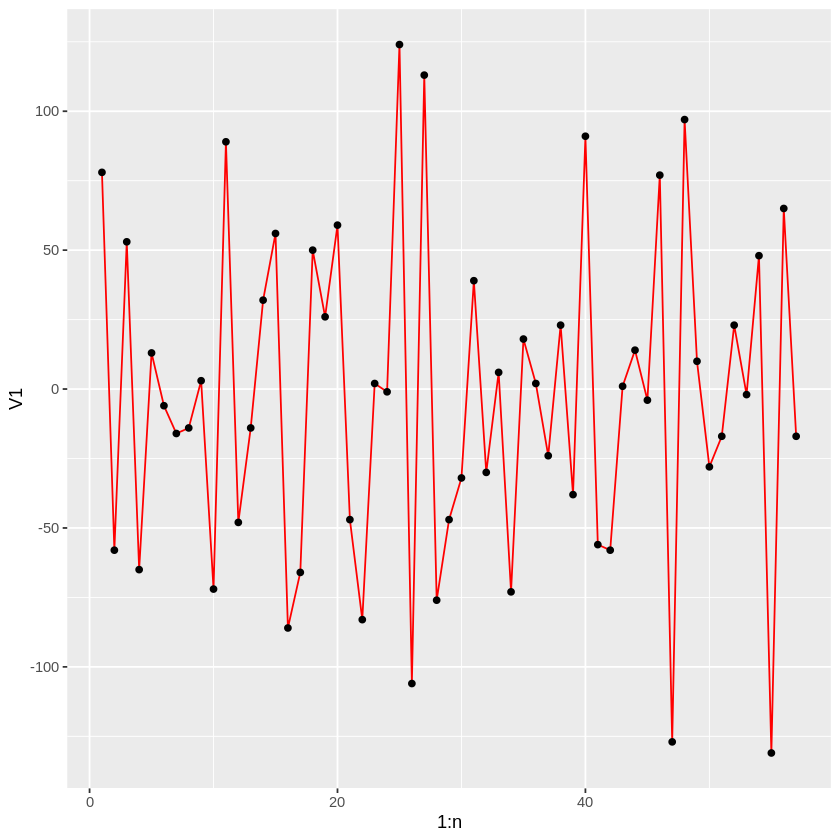

In [35]:
# Exemplo
url = "http://leg.ufpr.br/~lucambio/CE017/20212S/oshorts.tsm"
dados = read.table(url)
n = nrow(dados)

ggplot(dados) + 
  geom_line(aes(x = 1:n, y = V1), color = "red") +
  geom_point(aes(x = 1:n, y = V1)) 

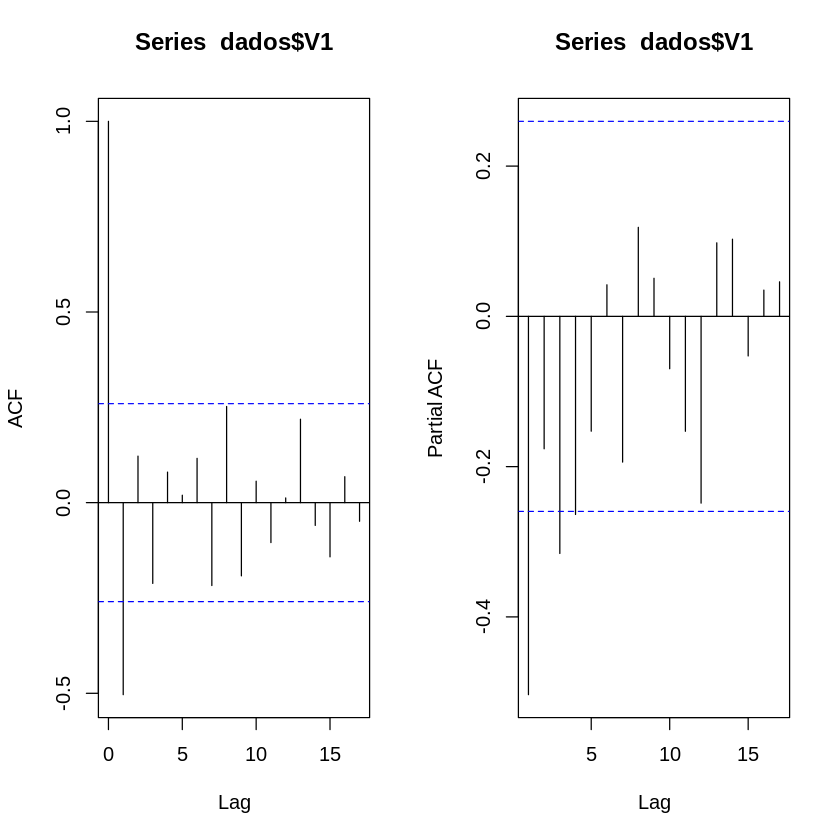

In [3]:
op = par(mfrow = c(1, 2))
acf(dados$V1)
pacf(dados$V1)
par(op)

In [4]:
summary(dados$V1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-131.000  -47.000   -2.000   -4.035   32.000  124.000 

In [5]:
fit_01 = arima(dados$V1, order = c(0, 0, 1), include.mean = TRUE)
fit_01


Call:
arima(x = dados$V1, order = c(0, 0, 1), include.mean = TRUE)

Coefficients:
          ma1  intercept
      -0.8473    -4.7798
s.e.   0.1205     1.0267

sigma^2 estimated as 2020:  log likelihood = -298.42,  aic = 602.84

Note que neste caso, temos ajustado um ARMAX(0,1) com $X_{t1} = 1$, $\forall t$.

In [6]:
Box.test(fit_01$residuals, lag = 10, fitdf = 2)


	Box-Pierce test

data:  fit_01$residuals
X-squared = 7.2255, df = 8, p-value = 0.5125


In [7]:
Box.test(fit_01$residuals, type = "Ljung-Box", lag = 10, fitdf = 2)


	Box-Ljung test

data:  fit_01$residuals
X-squared = 8.5225, df = 8, p-value = 0.3842


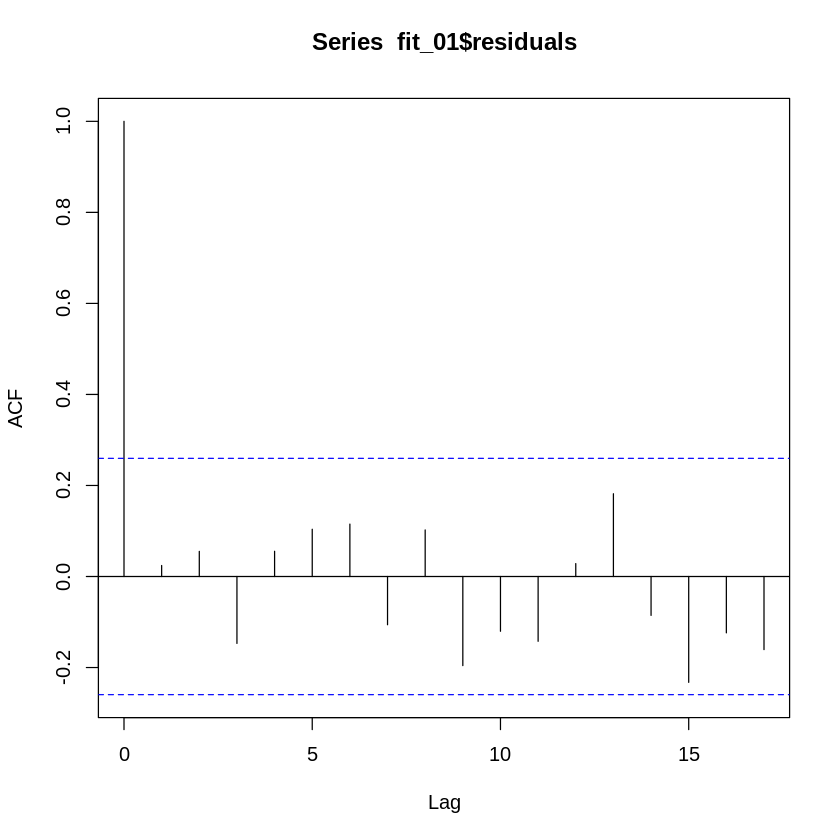

In [8]:
acf(fit_01$residuals)

## Estimação

- Em um contexto de regressão, estimamos os parâmetros minimizando a SQR (mas assumimos que os resíduos são iid).
- No nosso caso, se estimarmos os parâmetros minimizando a soma de quadrados dos $\eta$, $\hat{\beta}$ não serão mais BLUE, os testes T não são mais válidos, AICc não é mais um bom criterio para selecionar o melhor modelo, etc.
- Minimizar a soma de quadrados dos $\epsilon$ evita esses problemas Alternativamente, podemos utilizar o método de máxima verosimilhança. 




#### Observações:

- Para estimar um modelo de regressão com erros ARMA, todas as séries devem ser estacionárias.
- Se estimarmos o modelo com alguma das variáveis sendo não estacionária, os estimadores não serão mais consistente (a única exceção é quando séries não estacionárias são co-integráveis, mas não abordaremos esse tema aqui).
- Se alguma série não for estacionária, devemos torna-la estacionária primeiro.
- Se formos diferencias uma séries para torná-la estacionárias, devemos diferenciar todas as séries para manter a relação entre $y_t$ e as variáveis explicativas.
- Note que, se todas as variáveis no modelo forem estacionárias, apenas temos que considerar erros ARMA. 


### Exemplo 02 (Hyndman 3 Athanasopoulos, 2021): US Personal Consumption and Income

O _dataset_ `us_change` do pacote _fpp3_ contem informação das mudanças trimestrais nas despesas de consumo pessoal e renda disponível pessoal entre 1970 e 2019-Q2. Queremos fazer previsão para as mudanças nas despesas de consumo pessoal baseados na renda. 

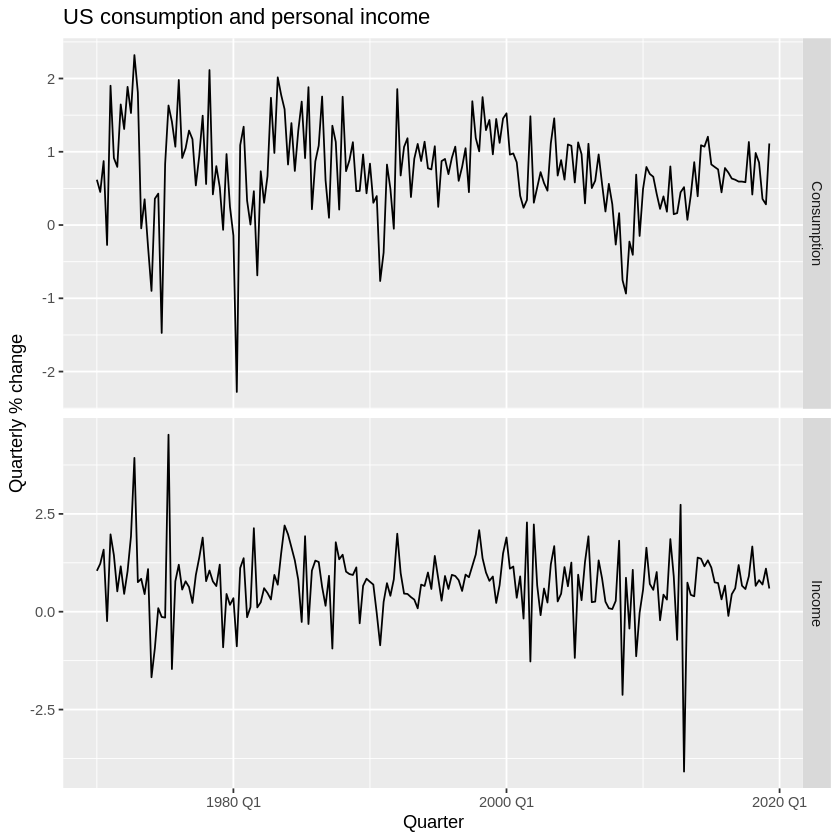

In [36]:
us_change |>
  pivot_longer(c(Consumption, Income),
               names_to = "var", values_to = "value") |>
  ggplot(aes(x = Quarter, y = value)) +
  geom_line() +
  facet_grid(vars(var), scales = "free_y") +
  labs(title = "US consumption and personal income",
       y = "Quarterly % change")

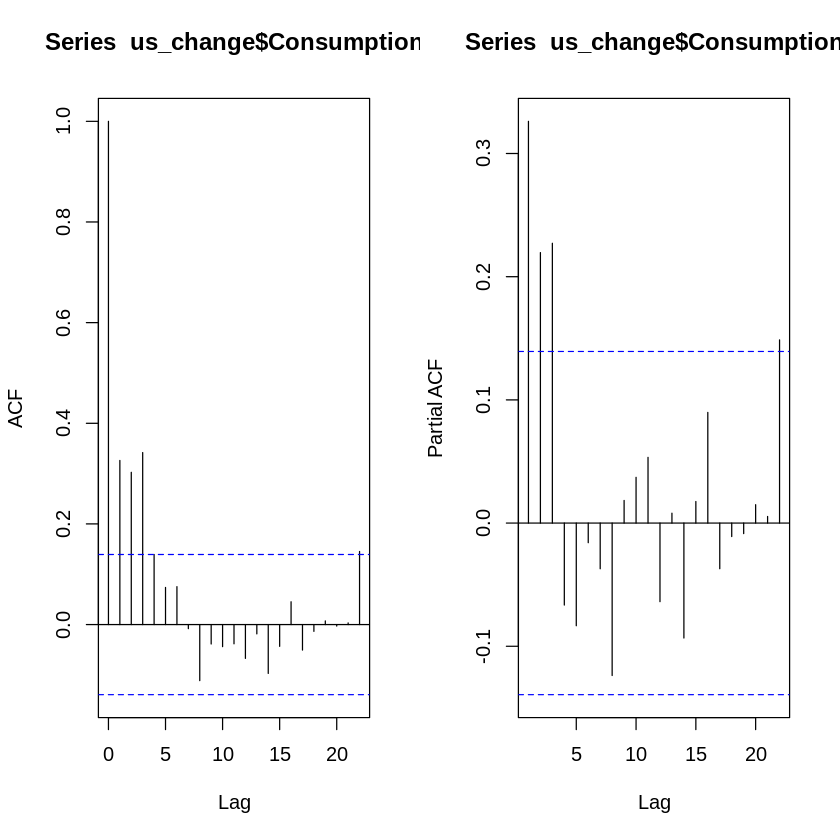

In [37]:
op = par(mfrow = c(1,2))
acf(us_change$Consumption)
pacf(us_change$Consumption)
par(op)

In [14]:
fit_04 <- us_change |>
  model(ARIMA(Consumption ~ Income))  # se não colocarmos pdq(,,) é feita uma escolha automática
report(fit_04)

Series: Consumption 
Model: LM w/ ARIMA(1,0,2) errors 

Coefficients:
         ar1      ma1     ma2  Income  intercept
      0.7070  -0.6172  0.2066  0.1976     0.5949
s.e.  0.1068   0.1218  0.0741  0.0462     0.0850

sigma^2 estimated as 0.3113:  log likelihood=-163.04
AIC=338.07   AICc=338.51   BIC=357.8


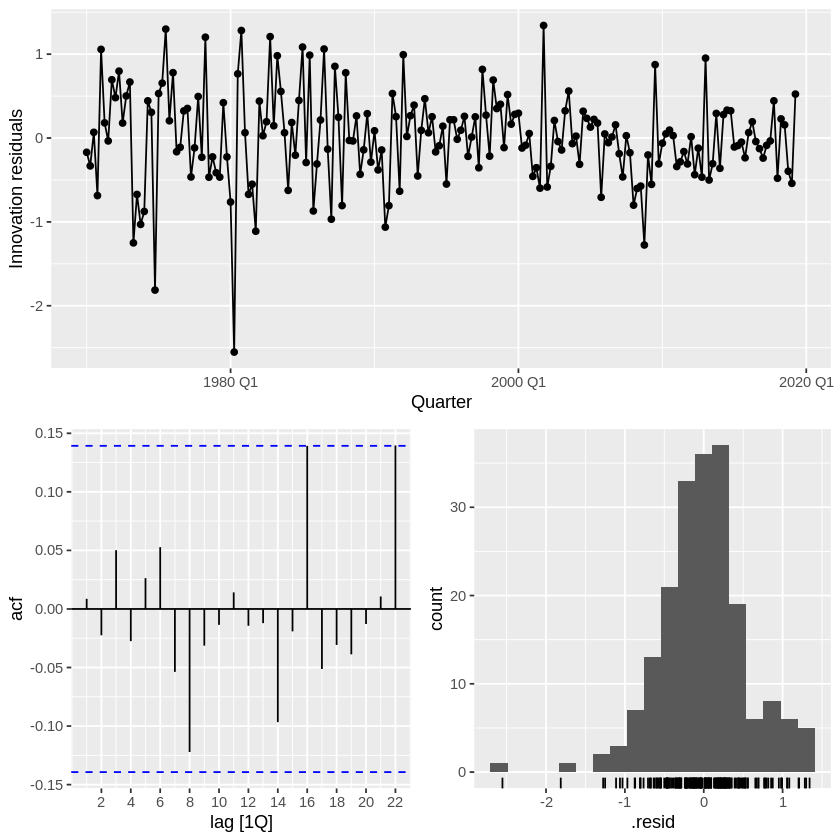

In [15]:
fit_04 |> gg_tsresiduals()

In [16]:
Box.test(augment(fit_04)$.innov, lag = 10, fitdf = 5)


	Box-Pierce test

data:  augment(fit_04)$.innov
X-squared = 5.2075, df = 5, p-value = 0.3911


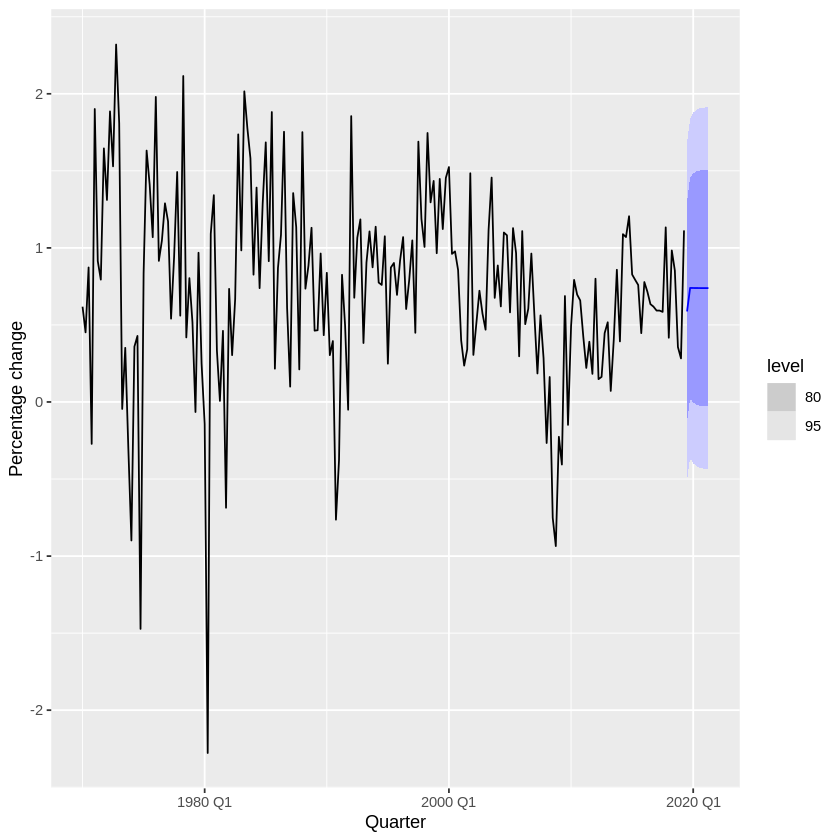

In [17]:
us_change_future <- new_data(us_change, 8) |>
  mutate(Income = mean(us_change$Income))
forecast(fit_04, new_data = us_change_future) |>
  autoplot(us_change) +
  labs(y = "Percentage change")

In [18]:
fit_05 = arima(us_change$Consumption, order = c(1, 0, 2), xreg = us_change$Income)
fit_05


Call:
arima(x = us_change$Consumption, order = c(1, 0, 2), xreg = us_change$Income)

Coefficients:
         ar1      ma1     ma2  intercept  us_change$Income
      0.7070  -0.6172  0.2066     0.5949            0.1976
s.e.  0.1068   0.1218  0.0741     0.0850            0.0462

sigma^2 estimated as 0.3035:  log likelihood = -163.04,  aic = 338.07

In [19]:
fit_06 = arima(us_change$Consumption, order = c(1, 0, 1), xreg = us_change$Income)
fit_07 = arima(us_change$Consumption, order = c(2, 0, 1), xreg = us_change$Income)
fit_08 = arima(us_change$Consumption, order = c(2, 0, 2), xreg = us_change$Income)

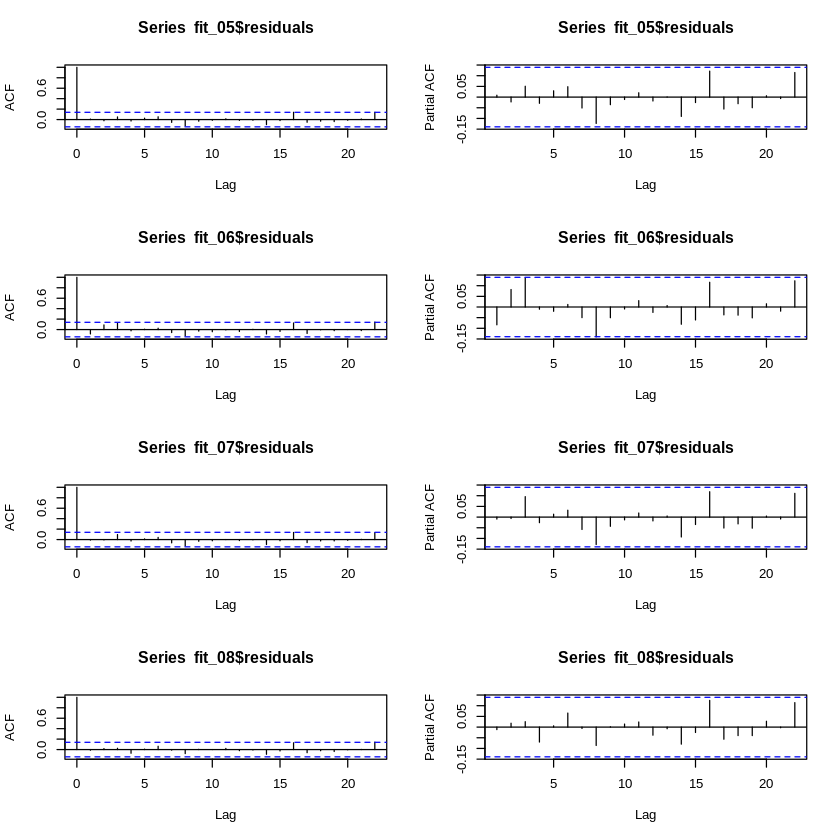

In [20]:
op = par(mfrow = c(4, 2))
acf(fit_05$residuals)
pacf(fit_05$residuals)
acf(fit_06$residuals)
pacf(fit_06$residuals)
acf(fit_07$residuals)
pacf(fit_07$residuals)
acf(fit_08$residuals)
pacf(fit_08$residuals)
par(op)

In [21]:
fit_05$aic

[1] 338.0722

In [22]:
fit_06$aic

[1] 342.4894

In [23]:
fit_07$aic

[1] 339.6372

In [24]:
fit_08$aic

[1] 338.5157

In [25]:
polyroot(c(1, -0.7070))

[1] 1.414427+0i

In [26]:
polyroot(c(1, -0.6172,  0.2066))

[1] 1.493708+1.615274i 1.493708-1.615274i

In [27]:
fit_05


Call:
arima(x = us_change$Consumption, order = c(1, 0, 2), xreg = us_change$Income)

Coefficients:
         ar1      ma1     ma2  intercept  us_change$Income
      0.7070  -0.6172  0.2066     0.5949            0.1976
s.e.  0.1068   0.1218  0.0741     0.0850            0.0462

sigma^2 estimated as 0.3035:  log likelihood = -163.04,  aic = 338.07

In [28]:
fit_06


Call:
arima(x = us_change$Consumption, order = c(1, 0, 1), xreg = us_change$Income)

Coefficients:
         ar1      ma1  intercept  us_change$Income
      0.8004  -0.5924     0.6108            0.1777
s.e.  0.0783   0.0999     0.0869            0.0456

sigma^2 estimated as 0.3136:  log likelihood = -166.24,  aic = 342.49

#### Exemplo 03 (Hyndman e Athanasopoulos, 2021): Forecasting electricity demand

A demanda de energía diária pode ser modelada em função da temperatura

In [29]:
glimpse(vic_elec)

Rows: 52,608
Columns: 5
$ Time        <dttm> 2012-01-01 00:00:00, 2012-01-01 00:30:00, 2012-01-01 01:0…
$ Demand      <dbl> 4382.825, 4263.366, 4048.966, 3877.563, 4036.230, 3865.597…
$ Temperature <dbl> 21.40, 21.05, 20.70, 20.55, 20.40, 20.25, 20.10, 19.60, 19…
$ Date        <date> 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-0…
$ Holiday     <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE…


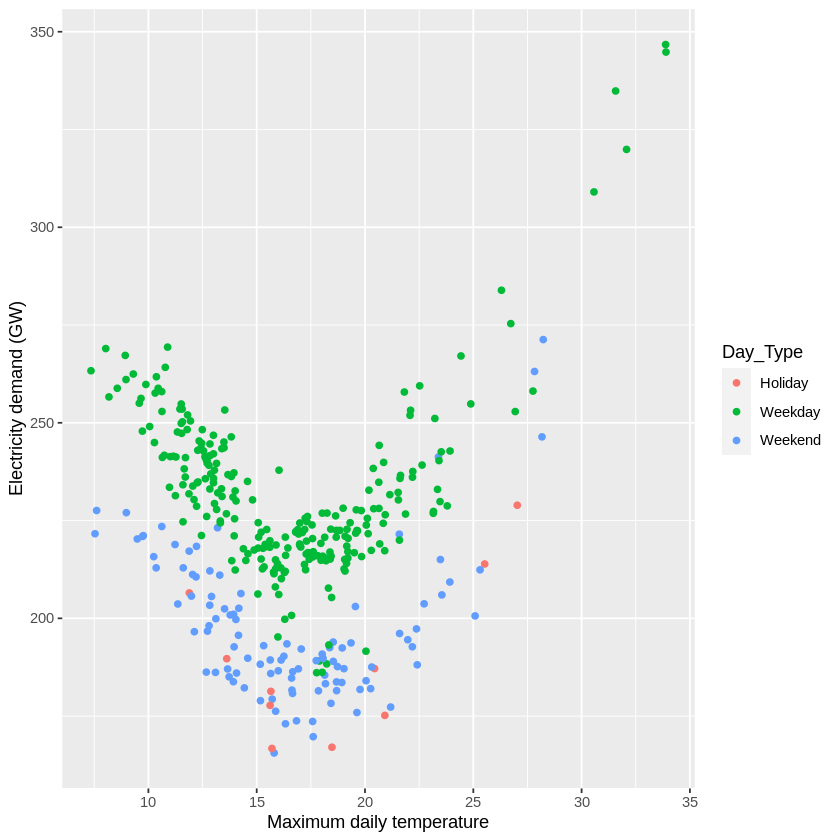

In [30]:
vic_elec_daily <- vic_elec |>
  filter(year(Time) == 2014) |>
  index_by(Date = date(Time)) |>
  summarise(
    Demand = sum(Demand) / 1e3,
    TemperatureMean = mean(Temperature),
    TemperatureMax = max(Temperature),
    TemperatureMin = min(Temperature),
    Holiday = any(Holiday)
  ) |>
  mutate(Day_Type = case_when(
    Holiday ~ "Holiday",
    wday(Date) %in% 2:6 ~ "Weekday",
    TRUE ~ "Weekend"
  ))

vic_elec_daily |>
  ggplot(aes(x = TemperatureMean, y = Demand, colour = Day_Type)) +
  geom_point() +
  labs(y = "Electricity demand (GW)",
       x = "Maximum daily temperature")

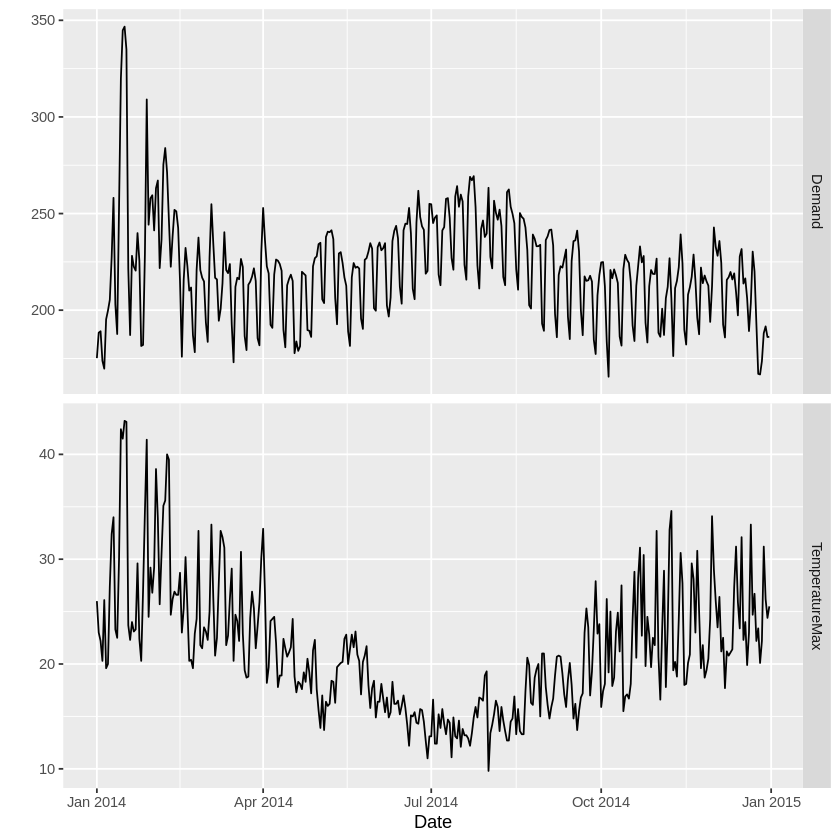

In [41]:
vic_elec_daily |>
  pivot_longer(c(Demand, TemperatureMax)) |>
  ggplot(aes(x = Date, y = value)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") + ylab("")

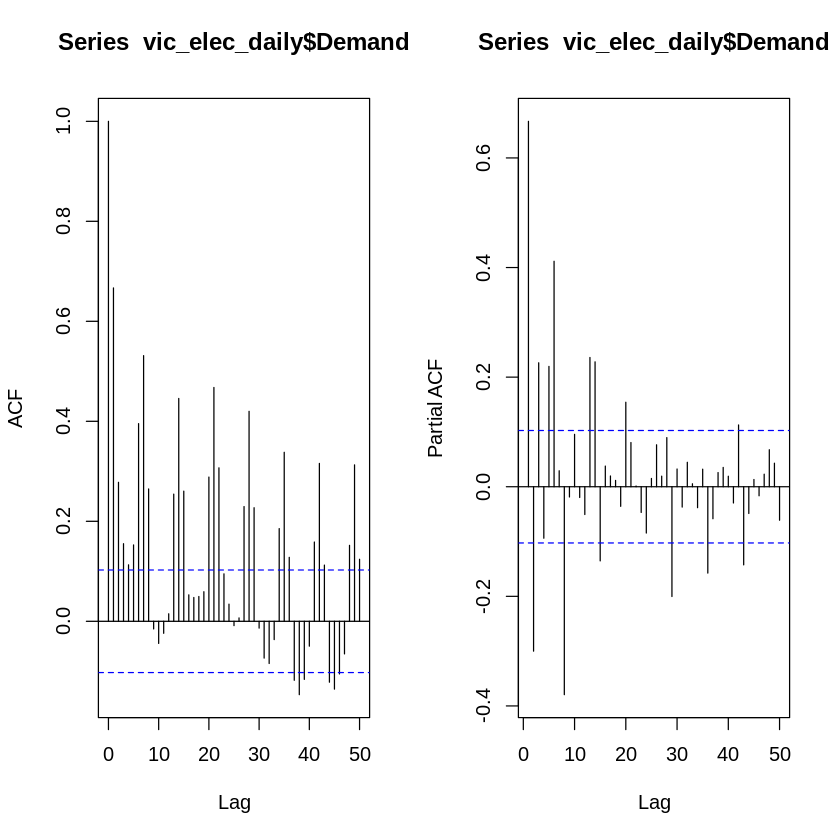

In [42]:
op = par(mfrow = c(1,2))
acf(vic_elec_daily$Demand, 50)
pacf(vic_elec_daily$Demand, 50)
par(op)

In [46]:
fit_09 <- vic_elec_daily |>
  model(ARIMA(Demand))
report(fit_09)

Series: Demand 
Model: ARIMA(1,0,4)(0,1,1)[7] w/ drift 

Coefficients:
         ar1      ma1      ma2      ma3      ma4     sma1  constant
      0.9365  -0.0305  -0.2204  -0.1258  -0.1404  -0.9207   -0.0174
s.e.  0.0474   0.0731   0.0713   0.0621   0.0767   0.0313    0.0334

sigma^2 estimated as 171.1:  log likelihood=-1431.41
AIC=2878.82   AICc=2879.24   BIC=2909.87


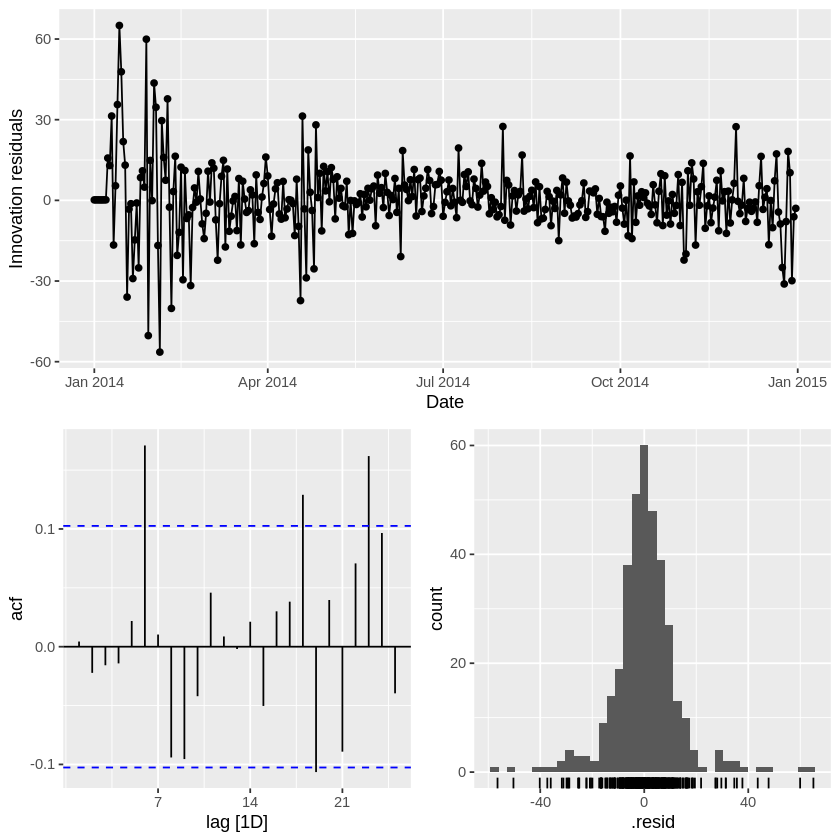

In [47]:
fit_09 |> gg_tsresiduals()

In [48]:
fit_10 <- vic_elec_daily |>
  model(ARIMA(Demand ~ TemperatureMax + I(TemperatureMax^2) +
                (Day_Type == "Weekday")))
report(fit_10)

Series: Demand 
Model: LM w/ ARIMA(2,1,2)(2,0,0)[7] errors 

Coefficients:
          ar1     ar2      ma1      ma2    sar1    sar2  TemperatureMax
      -0.1093  0.7226  -0.0182  -0.9381  0.1958  0.4175         -7.6135
s.e.   0.0779  0.0739   0.0494   0.0493  0.0525  0.0570          0.4482
      I(TemperatureMax^2)  Day_Type == "Weekday"TRUE
                   0.1810                    30.4040
s.e.               0.0085                     1.3254

sigma^2 estimated as 44.91:  log likelihood=-1206.11
AIC=2432.21   AICc=2432.84   BIC=2471.18


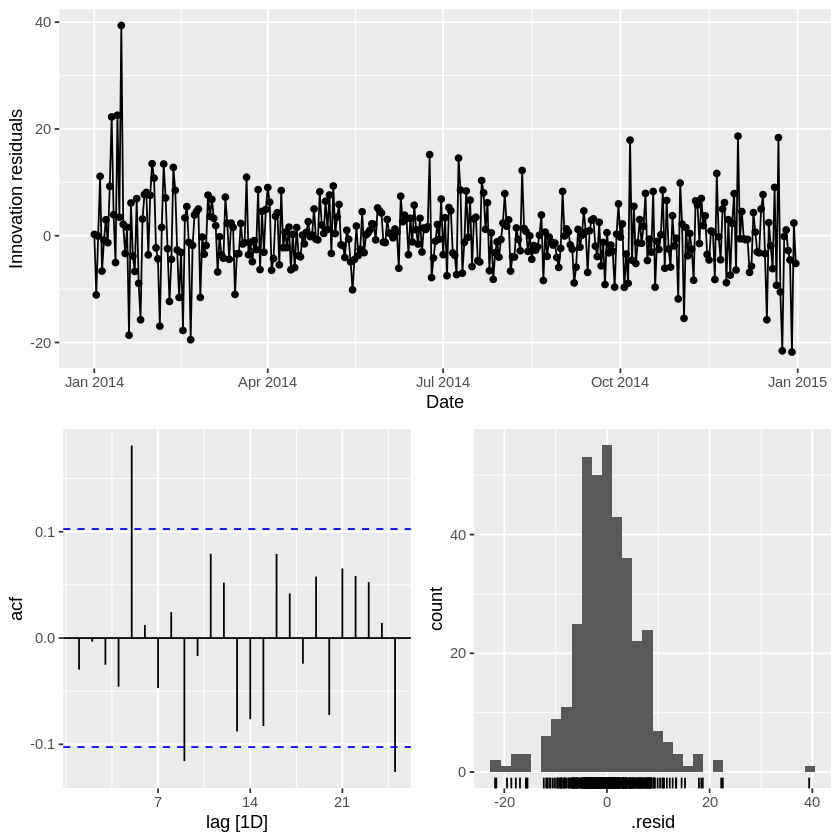

In [50]:
fit_10 |> gg_tsresiduals()

In [53]:
fit_11 <- vic_elec_daily |>
  model(ARIMA(Demand ~ TemperatureMean + I(TemperatureMean^2) +
                (Day_Type == "Weekday")))
report(fit_11)

Series: Demand 
Model: LM w/ ARIMA(4,1,0)(2,0,0)[7] errors 

Coefficients:
          ar1     ar2      ar3      ar4    sar1    sar2  TemperatureMean
      -0.2312  -0.192  -0.2465  -0.0911  0.2490  0.2755         -12.1359
s.e.   0.0557   0.053   0.0538   0.0552  0.0527  0.0552           0.5671
      I(TemperatureMean^2)  Day_Type == "Weekday"TRUE
                    0.3788                    31.2465
s.e.                0.0140                     1.0709

sigma^2 estimated as 38.21:  log likelihood=-1176.09
AIC=2372.18   AICc=2372.8   BIC=2411.15


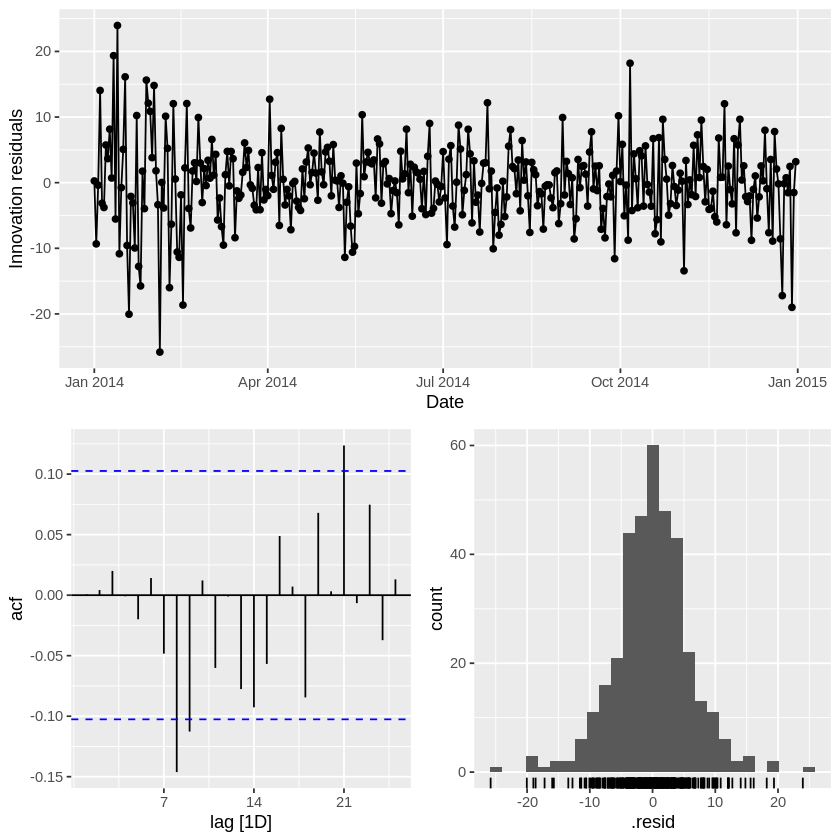

In [52]:
fit_11 |> gg_tsresiduals()

## Referencias

- Huang, C., & Petukhina, A. (2022). Applied Time Series Analysis and Forecasting with Python. Springer Nature.
- Hyndman, R. (2010). The ARIMAX model muddle, retreived from https://robjhyndman.com/hyndsight/arimax/
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Capítulo 10.
